__семантический сегментатор изображений__

Евгений Борисов <esborisov@sevsu.ru>

Fully Convolutional Networks for Semantic Segmentation  
Jonathan Long, Evan Shelhamer, Trevor Darrell  
UC Berkeley  
8 Mar 2015  

https://arxiv.org/pdf/1411.4038.pdf

In [1]:
import os
import numpy as np
from numpy import random as rng
from PIL import Image

In [2]:
import torch
import torchvision

## подгружаем модель

https://towardsdatascience.com/review-fcn-semantic-segmentation-eb8c9b50d2d1

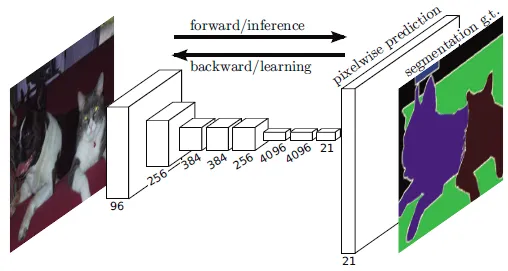

In [3]:
# подгружаем предобученную модель FCN

# ~/.cache/torch/hub/checkpoints/fcn_resnet101_coco-7ecb50ca.pth

# from torchvision.models.segmentation import fcn_resnet50
# model = fcn_resnet50(pretrained=True)

from torchvision.models.segmentation import fcn_resnet101
model = fcn_resnet101(pretrained=True)

model = model.train(False)

/opt/venv/sevgu_1/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/venv/sevgu_1/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FCN_ResNet101_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=FCN_ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [4]:
# имена классов датасета, на которм обучаласть модель
class_name = [
    'background','aeroplane','bicycle','bird','boat',
    'bottle','bus','car','cat','chair','cow','diningtable',
    'dog','horse','motorbike','person','potted plant',
    'sheep','sofa','train','tv/monitor', ]

n_classes = len(class_name) # количество классов

## тестируем

данные https://disk.yandex.ru/d/KEZSpmlzTekTgw

In [5]:
img_folder = 'data/pascal/samples'
files = os.listdir(img_folder)

In [10]:
from matplotlib import pyplot as plt
import torchvision.transforms as transforms

# преобразование фотографии в torch.tensor
img_transforms = transforms.Compose([ 
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225]),
        ])
# img_transforms(img).unsqueeze(0).shape


def get_mask(x,model=model): 
    with torch.no_grad(): # отключаем расчёт градиента
        o = model(x) # считаем выход модели
    # тензор оценок - для каждой точки изображения имеем вектор оценок по количеству классов
    scores = torch.squeeze(o['out'],dim=0).detach().numpy() 
    # для каждой точки выбираем класс с максимальной оценкой
    point_class = np.argmax(scores,axis=0)
    return { # формируем маски классов 
            #  <номер класса>:<бинарная маска изображения>
            c:(point_class==c).astype(np.uint8) 
            for c in range( point_class.max()+1 ) 
            if (point_class==c).any() # только для классов с непустыми масками
        }

# рисуем результат
def plot_result( img, im_mask, cols=2, figsize=(10,10),):
    rows = len(im_mask)//cols+1
    fig = plt.figure(figsize=figsize)
    plt.subplot(rows,cols,1)
    plt.axis(False)
    plt.imshow(img)
    i=2
    for c in im_mask:
        plt.subplot(rows,cols,i)
        plt.title(class_name[c])
        plt.axis(False)
        plt.imshow(im_mask[c])
        i+=1
    fig.tight_layout()    

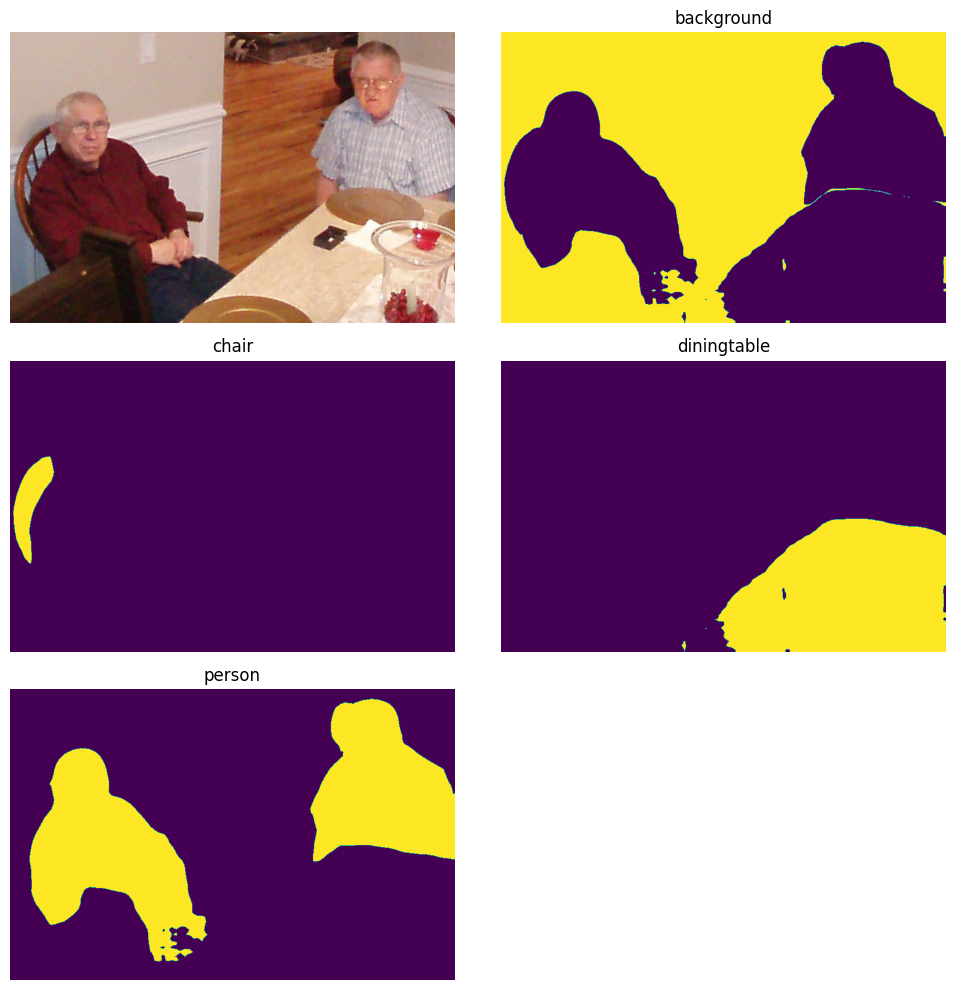

In [11]:
# выбираем случайное фото
img = Image.open(os.path.join(img_folder, rng.choice(files) ))
x = img_transforms(img).unsqueeze(dim=0) # преобразуем фото в torch.tensor
mask = get_mask(x)
plot_result( img, mask )